# Train MiniGPT to Narrate Short Stories

After constrcucting the decoder only Transformer architecture from scratch following Day 4 and 5, building a GPT model is all about scaling it up.

**Original GPT - 1 architecture**

* Total number of Parameters :  **117M**
* Trained on : **985M tokens**
* Number of Transformer layer stcaked: **12**
* Embedding Dimension: **768-D** word embeddings and positional encodings
* Attention: **12** multi-head self-attention heads per block (each head handling 64 dimensions, totaling 768)
* Feed-Forward Network (FFN): **3072** Neurons
* Context Size: **512** tokens

Due to compute limitations, we can train a smaller model, which we call as miniGPT. This is roughly 6% of the size of original GPT 1 model with 6.4M parameters. The model is trained to generate/narrate short stories.

**MiniGPT architecture**

* Total number of Parameters :  **6.4M**
* Trained on : **250K tokens**
* Number of Transformer layer stcaked: **2**
* Embedding Dimension: **256-D** word embeddings and positional encodings
* Attention: **16** multi-head self-attention heads per block (each head handling 64 dimensions, totaling 768)
* Feed-Forward Network (FFN): **512** Neurons
* Context Size: **512** tokens

**Updates from Transformer Architecture to develop miniGPT**

> **Dataset used**: ROC Stories dataset developed at University of Rochester for NLP tasks. The training data is created not just to complete a sentence, but to develop a coherent short story

> **Tokenizer** : Byte-Pair Encoding (BPE) is used just like in GPT models. It is a subword tokenization technique that generates a vocabulary of subword units, which are then embedded using a model (e.g., Transformer embeddings in T5 or GPT). It bridges word-level and character-level representations, balancing vocabulary size and flexibility

> **Temperature Sampling** : Instead of generating a fixed next token (based on highest softmax probability), the entire probability distribution is used to sample the next token. The randomness in sample generation can be controlled with the temperature value, which scales the logits before applying softmax to flatten the distribution.

**Model Architecture Visualization**



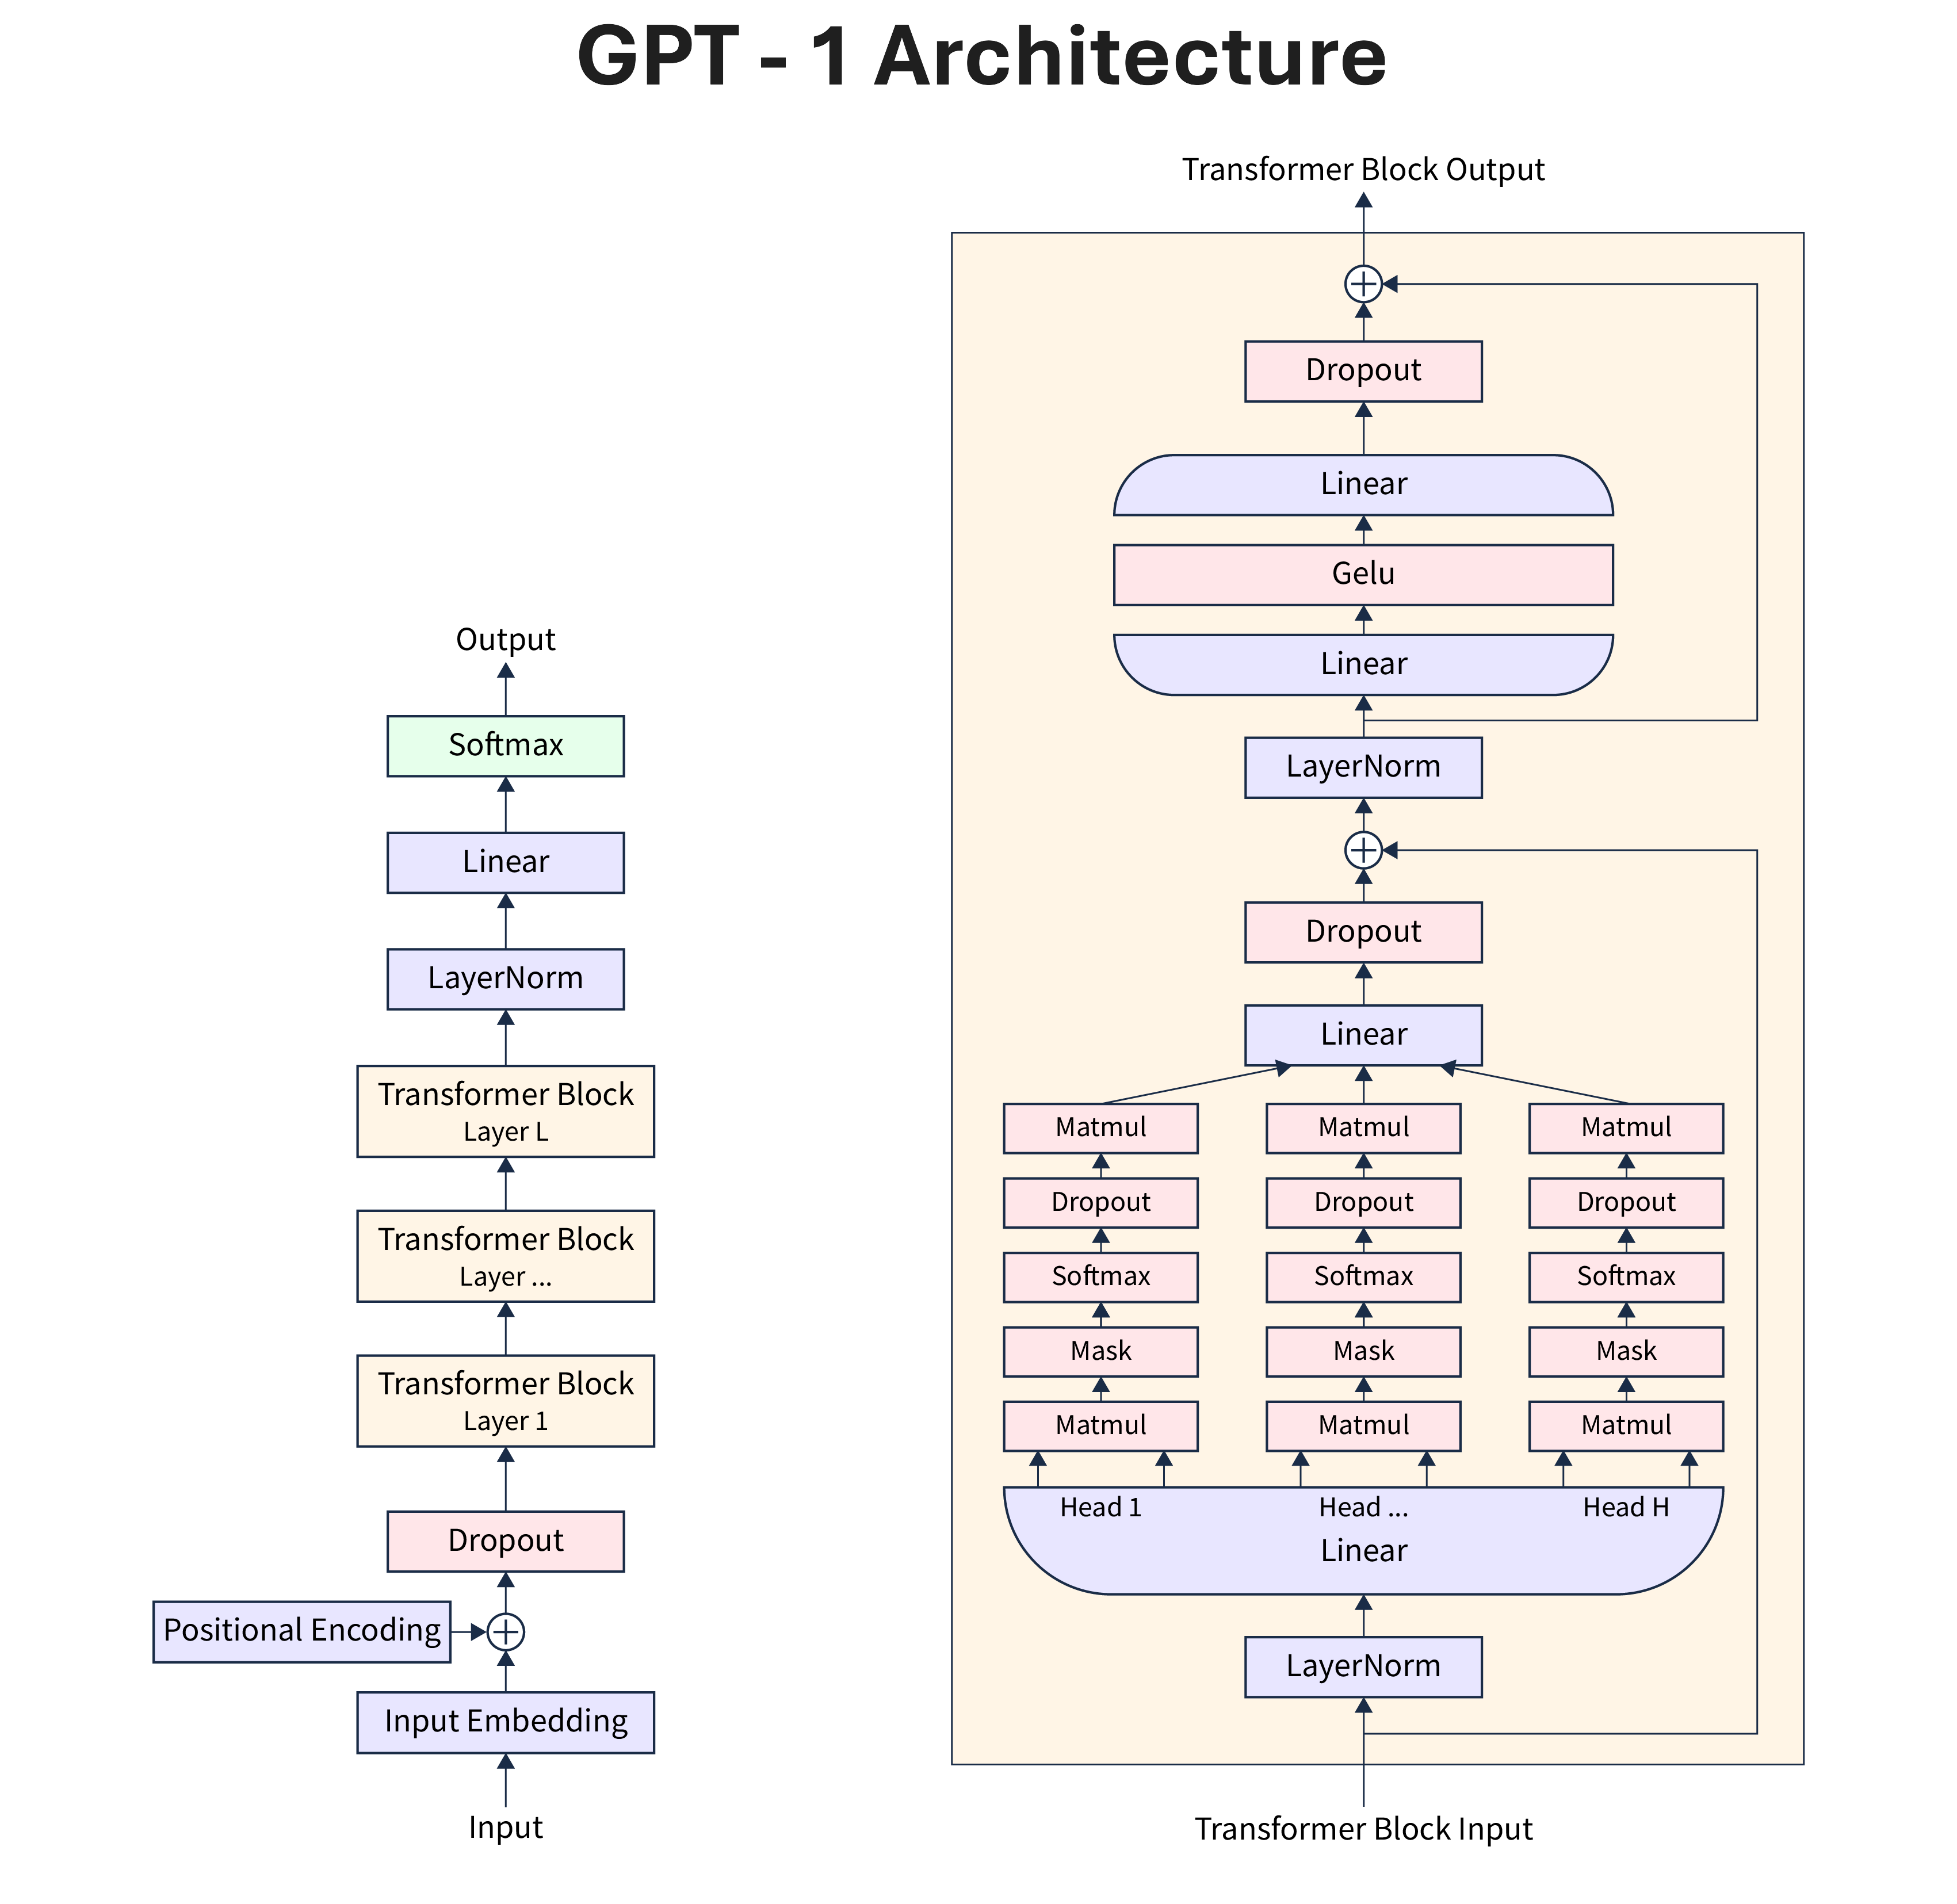

In [1]:
# Import relevant libraries

! pip install -q lightning

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import lightning as L
# Ignore all warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Position encoding

In [2]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model=2, max_len=6):
        super().__init__()
        pe = torch.zeros(max_len, d_model)

        # Precompute positional encodings
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension for broadcasting: [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        """
        Add positional encodings to batched word embeddings.
        Args:
            word_embeddings: [batch_size, seq_len, d_model]
        Returns:
            [batch_size, seq_len, d_model]
        """
        seq_len = word_embeddings.size(1)  # Get sequence length from dim 1
        # Slice pe to match seq_len: [1, seq_len, d_model]
        pe_slice = self.pe[:, :seq_len, :]
        # Broadcasting adds pe to each sequence in the batch
        return word_embeddings + pe_slice

## Multihead Attention Block

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=2, num_heads=2):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for queries, keys, values, and output
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        batch_size, seq_len, _ = encodings_for_q.shape  # Shape: [batch_size, seq_len, d_model]

        # Linear projections
        q = self.W_q(encodings_for_q)  # [batch_size, seq_len, d_model]
        k = self.W_k(encodings_for_k)  # [batch_size, seq_len, d_model]
        v = self.W_v(encodings_for_v)  # [batch_size, seq_len, d_model]

        # Split into heads: [batch_size, num_heads, seq_len, d_k]
        q = q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores: [batch_size, num_heads, seq_len, seq_len]
        sims = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1)  # [batch_size, 1, seq_len, seq_len] for broadcasting
            sims = sims.masked_fill(mask, -1e9)

        # Softmax to get attention weights
        attention_percents = F.softmax(sims, dim=-1)

        # Compute attention output: [batch_size, num_heads, seq_len, d_k]
        attention_output = torch.matmul(attention_percents, v)

        # Concatenate heads: [batch_size, seq_len, d_model]
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Final linear projection: [batch_size, seq_len, d_model]
        output = self.W_o(attention_output)
        return output

## Decoder layer

In [4]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=2, num_heads=2, d_ff=8, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Self-attention sub-layer
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))  # Residual + norm

        # Feed-forward sub-layer
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))  # Residual + norm
        return x

## Decoder Only Transformer - Main class

In [5]:
class DecoderOnlyTransformer(L.LightningModule):
    def __init__(self, num_tokens=4, d_model=2, num_heads=2, num_layers=6, d_ff=8, max_len=6, dropout=0.1):
        super().__init__()
        L.seed_everything(seed=42)
        self.num_tokens = num_tokens
        self.d_model = d_model

        # Embedding and positional encoding
        self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model, max_len=max_len)
        self.dropout = nn.Dropout(dropout)

        # Stack 6 decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Output layer
        self.fc_layer = nn.Linear(d_model, num_tokens)
        self.loss = nn.CrossEntropyLoss(ignore_index=0)

    def forward(self, token_ids, attention_mask=None):
        batch_size, seq_len = token_ids.shape

        # Embeddings and positional encoding
        word_embeddings = self.we(token_ids)  # [batch_size, seq_len, d_model]
        x = self.pe(word_embeddings)
        x = self.dropout(x)

        # Create masks
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(token_ids.device) == 0
        causal_mask = causal_mask.unsqueeze(0).expand(batch_size, -1, -1)
        if attention_mask is None:
            padding_mask = (token_ids == 0).unsqueeze(1).expand(-1, seq_len, -1)
        else:
            padding_mask = (attention_mask == 0).unsqueeze(1).expand(-1, seq_len, -1)
        final_mask = causal_mask | padding_mask

        # Pass through 6 stacked layers
        for layer in self.layers:
            x = layer(x, mask=final_mask)  # [batch_size, seq_len, d_model]

        # Final output
        fc_layer_output = self.fc_layer(x)  # [batch_size, seq_len, num_tokens]
        return fc_layer_output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00025)

    def training_step(self, batch, batch_idx):
        input_tokens, labels = batch
        output = self.forward(input_tokens)
        loss = self.loss(output.view(-1, self.num_tokens), labels.view(-1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

## Get training data

In [6]:
! pip install -q datasets
! pip install -q contractions

from datasets import load_dataset
import nltk
import regex as re
from contractions import contractions_dict
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.1 MB/s eta 0:00:00


In [7]:
# Install required libraries
from datasets import load_dataset
import os

def clean_text(text):
    # Optional: Remove special characters (keep if meaningful)
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    # Optional: Lowercase (skip if preserving case like GPT-1)
    text = text.lower()
    # Remove extra whitespace and normalize
    text = re.sub(r'\s+', ' ', text.strip())

    return text

# !pip install -q datasets

def get_roc_stories(num_stories):
    file_path = "ROC_data_train.txt"

    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the entire file and split by double newline
        raw_stories = file.read().strip().split('\n')
    stories_list = []
    for each in raw_stories:
        clened_text = clean_text(each)
        stories_list.append(clened_text)
    if num_stories == "All":
        return stories_list
    return stories_list[:num_stories]

In [8]:
# Get token_to_id and id_to_token
# Tokenize all stories and count unique tokens
def get_dicts_from_stories(stories):
  from collections import Counter
  all_tokens = []
  for story in stories:
      tokens = tokenizer.tokenize(story)
      all_tokens.extend(tokens)

  # Build a reduced vocabulary
  token_counts = Counter(all_tokens)
  seen_vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.items())}
  seen_vocab["<pad>"] = 0  # Add padding token
  token_to_id = seen_vocab
  id_to_token = {idx: token for token, idx in token_to_id.items()}
  return token_to_id, id_to_token

In [9]:
def prepare_inputs_labels_from_stories(stories,t_to_i,max_len_local):
  inputs_list = []
  labels_list = []

  for story in stories:
      tokens_global = tokenizer.tokenize(story)
                        #  , truncation=True, max_length=max_len_local, return_tensors="pt")["input_ids"].squeeze(0)
      tokens = [t_to_i.get(token, t_to_i["<pad>"]) for token in tokens_global]
      if len(tokens) < 2:  # Skip if too short
          continue
      # Input: all but last token, Label: all but first token
      input_ids = torch.tensor(tokens[:-1][:max_len_local])
      label_ids = torch.tensor(tokens[1:][:max_len_local])
      # Pad to max_len
      padding_length = max_len_local - len(input_ids)
      if padding_length > 0:
          input_ids = torch.cat([input_ids, torch.full((padding_length,), 0)]) #pad_token_id = 0
          label_ids = torch.cat([label_ids, torch.full((padding_length,), 0)]) #pad_token_id = 0
      inputs_list.append(input_ids)
      labels_list.append(label_ids)
  inputs_list_tensor = torch.stack(inputs_list)
  labels_list_tensor = torch.stack(labels_list)
  return inputs_list_tensor, labels_list_tensor

In [10]:
# BPE tokenizer from transformers import T5Tokenizer
from transformers import GPT2Tokenizer
# Load tokenizer
# Note we are using the tokenizer used in GPT2 for better performance instead of keeping tokens = words
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as EOS

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Get final data

In [12]:
n = 5000
stories = get_roc_stories(5000)
print("Stories:",len(stories))
token_to_id, id_to_token = get_dicts_from_stories(stories)
len(token_to_id), len(id_to_token)

Stories: 5000


(10411, 10411)

In [13]:
context_len = 512
a,b = prepare_inputs_labels_from_stories(stories,token_to_id,context_len)
print(len(a), a.shape)
dataset_new = TensorDataset(a, b)
dataloader = DataLoader(dataset_new, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)

5000 torch.Size([5000, 512])


# Build miniGPT model

In [14]:
model = DecoderOnlyTransformer(num_tokens= len(token_to_id), d_model = 256,num_heads=16, num_layers=2, d_ff=512, max_len = context_len, dropout=0.1)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [15]:
# count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 6393003


##  Train the model

In [16]:
# Ensure Google Drive is mounted
import os
# from google.colab import drive
# drive.mount('/content/drive')

save_loc_my_drive = "<path to save model>"

class SaveCheckpointCallback(L.Callback):
    def __init__(self, save_freq=2, save_dir=save_loc_my_drive):
        super().__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        # Create directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)
        # print(f"Initialized callback with save_dir: {self.save_dir}")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        # print(f"Epoch {epoch + 1} ended")  # Debug to confirm callback is called
        if (epoch + 1) % self.save_freq == 0:
            # print("Now is the time to save the model")  # Debug save trigger
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': pl_module.state_dict(),
                'optimizer_state_dict': trainer.optimizers[0].state_dict(),
            }
            filename = f"day_6_model_{epoch + 1}.pt"
            try:
                torch.save(checkpoint, filename)
                print(f"Saved checkpoint at {epoch + 1}: {filename}")
            except Exception as e:
                print(f"Failed to save checkpoint: {e}")

# Training setup
checkpoint_callback = SaveCheckpointCallback(save_freq=25, save_dir=save_loc_my_drive)
trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback],
    accelerator="auto",
    devices=1,
    enable_progress_bar=True,
)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | we       | Embedding        | 2.7 M  | train
1 | pe       | PositionEncoding | 0      | train
2 | dropout  | Dropout          | 0      | train
3 | layers   | ModuleList       | 1.1 M  | train
4 | fc_layer | Linear           | 2.7 M  | train
5 | loss     | CrossEntropyLoss | 0      | train
------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.572    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
Training: |          | 200/200 [00:25<00:00,  6.19it/s, v_num=1, train_loss=0.939
Saved checkpoint at 25: day_6_model_25.pt
Saved checkpoint at 50: day_6_model_50.pt

## Model inference

In [18]:
def model_inference(model, prompt,token_to_id,response_type, temperature,sentences):
    tokens_big = tokenizer.tokenize(prompt)
    prompt_tokens = [token_to_id.get(token, token_to_id["<pad>"]) for token in tokens_big]
    # print the prompt
    print("\033[91mPrompt:\033[0m")
    print(prompt)

    # response_type : 1 = Fixed
    torch.manual_seed(42)  # Fix random seed
    model.eval()           # Disable dropout and batch norm
    model_input = torch.tensor(prompt_tokens) #, token_to_id["is"], token_to_id["where"]

    model_input = model_input.unsqueeze(0)  # Shape: [1, seq_len]
    input_length = model_input.size(dim=1)  # Now use dim=1 for seq_len
    predictions = model(model_input)
    def pred_by_distribution(pred,temp):
        g = torch.Generator().manual_seed(1)
        prob = torch.softmax(pred[0][-1,:]/temp, dim=-1)
        pred_id = torch.multinomial(prob, num_samples=1, generator = g)
        return pred_id
    if response_type == 1:
        predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
    else:
        predicted_id = pred_by_distribution(predictions,temperature)
    predicted_ids = predicted_id

    sent_ct = 0
    while True:
        if predicted_id == token_to_id["."]:
            sent_ct +=1
        if sent_ct == sentences:
            break
        model_input = torch.cat((model_input, predicted_id.unsqueeze(0)), dim=1)
        predictions = model(model_input)
        if response_type == 1:
            predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
        else:
            predicted_id = pred_by_distribution(predictions,temperature)
        predicted_ids = torch.cat((predicted_ids, predicted_id))

    # print("Model Response:")
    print("\033[94mModel Response:\033[0m")
    for each in predicted_ids:
        print(id_to_token[each.item()].replace('Ġ', ''), end=" ", flush=True)
        if id_to_token[each.item()] == ".":
            print()
        time.sleep(.2)

## Sample stories from trained MiniGPT model

In [19]:
# Prompt - 1
prompt = "i love the sound of autotuned vocals."
model_inference(model, prompt,token_to_id,response_type = 1,temperature = 1,sentences = 3)

Prompt:
i love the sound of autotuned vocals.
Model Response:
i bought my own recording equipment for singing . 
i also bought some audio software so i could aut ot une myself . 
my tracks all turned out silly and erratic . 


In [20]:
# Prompt - 2
prompt = "i woke up am in the morning."
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 0.1,sentences = 6)

Prompt:
i woke up am in the morning.
Model Response:
i prepared breakfast and got a glass of milk . 
there was no cereal . 
i looked inside and saw a strange object . 
i looked in the mirror . 
i decided to call it out , where i could go . 
now i miss anything in it and ruined . 


In [21]:
# Prompt - 3
prompt = "one sunny day the sky suddenly became dark and cloudy."
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 0.5,sentences = 4)

Prompt:
one sunny day the sky suddenly became dark and cloudy.
Model Response:
this change in weather caught ke lly by surprise . 
she ran for cover under trees as she could . 
she chose the house next day . 
she ran straight to the ground and j ay went back to her room . 


In [22]:
# Prompt - 4
prompt = "my friend and i went"
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 1,sentences = 4)

Prompt:
my friend and i went
Model Response:
to the beach . 
we watched the sunset . 
they saw a mountain lake and went home . 
we saw a nice seafood salad . 
